## 5- ETL of Celular Dataset to later use

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from statistics import mean 

from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import matplotlib.pyplot       as plt
import seaborn                 as sns

### Loading the full celular dataset

In [2]:
df_all = pd.read_csv('../data/celular_data.csv', dtype={'gtin':'str'})
df_all['date'] = pd.to_datetime(df_all['date'])

### Basic ETL, basically transforming NaNs in median for stocks and equal to olist_price for competition prices

In [3]:
#filtering dates when stock >0
df = df_all[df_all['stock_avg'] >0]

#probably there's some way to do that easier...but I can't find it.
#calculate the median of freight_value by product_gtin
gtin_freight = df.groupby(['gtin'])['freight_value'].median()
gtin_freight = gtin_freight.fillna(0)

#split the datasets where freight_value = nan
df_freightna = df[df['freight_value'].isna() == True]
df_freightok = df[df['freight_value'].isna() == False]

#merge the freight_value median with the dataset with freight = na.
#drop the original freight_value column and rename the new.
df_freightna = df_freightna.merge(gtin_freight, on = 'gtin').drop(['freight_value_x'], axis = 1).rename({'freight_value_y' : 'freight_value'}, axis = 1)

#join the datasets with freight = nan and the others
df = df_freightok.append(df_freightna)

#fill competition_price nan as olist_price
df.competition_price = df.competition_price.fillna(df['olist_price'])

### Selecting columns to dataset

In [4]:
sel_col = ['date', 'gtin', 'item_name', 'competition_price', 'olist_price', 'freight_value', 'orders']
df = df[df.columns.intersection(sel_col)]

### Feature Engineering

In [5]:
df['price_ratio'] = df['olist_price'] / df['competition_price']
df['freight_ratio'] = df['freight_value'] / df['olist_price']
df['month'] = pd.DatetimeIndex(df['date']).month
df['monthday'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['week'] = pd.DatetimeIndex(df['date']).week

In [6]:
df['competition_price_sc'] = df.groupby('gtin').competition_price.transform(lambda x: minmax_scale(x.astype(float)))
df['price_sc'] = df.groupby('gtin').olist_price.transform(lambda x: minmax_scale(x.astype(float)))
df['freight_sc'] = df.groupby('gtin').freight_value.transform(lambda x: minmax_scale(x.astype(float)))

In [8]:
df['trend'] = df['date'].apply(lambda x: x.toordinal())

### Grouping by gtin to create some clusters

In [9]:
price_ratio = pd.DataFrame(df.groupby('gtin')['price_ratio'].mean())
freight_ratio = pd.DataFrame(df.groupby('gtin')['freight_ratio'].mean())
price = pd.DataFrame(df.groupby('gtin')['olist_price'].sum())

In [10]:
#Function to generate the elbow plot

def plot_elbow(dataframe):
    sum_sq_d = []
    K = range(1,10)

    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(dataframe)
        sum_sq_d.append(km.inertia_)
    
    plt.figure(figsize=(15,6))

    plt.plot(K, sum_sq_d, 'rx-.')

    plt.xlabel('Number of Clusters, k', fontsize=12)
    plt.xticks(K, fontsize=12)

    plt.ylabel('Sum of Squared Distances', fontsize=12)
    plt.xticks(fontsize=12)

    plt.title('Elbow Method For Determining k', fontsize=16)

    plt.show()

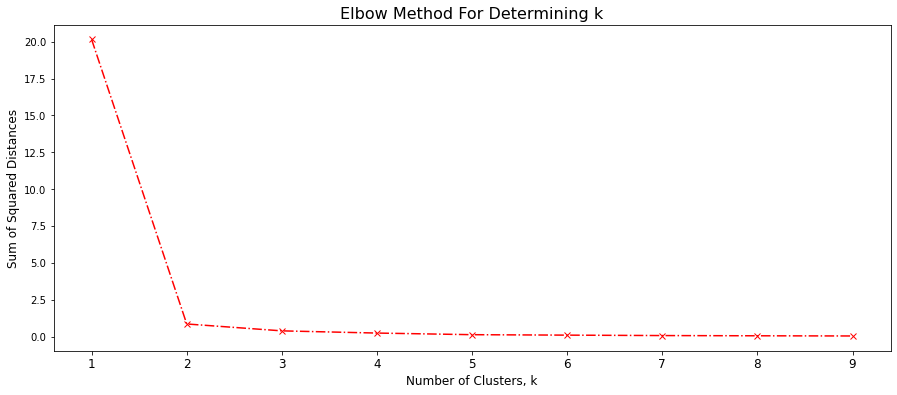

In [11]:
plot_elbow(price_ratio)

Ideal clusters 2

In [12]:
k = 2
km = KMeans(n_clusters=k)
price_ratio['cluster_price_ratio'] = km.fit_predict(price_ratio)

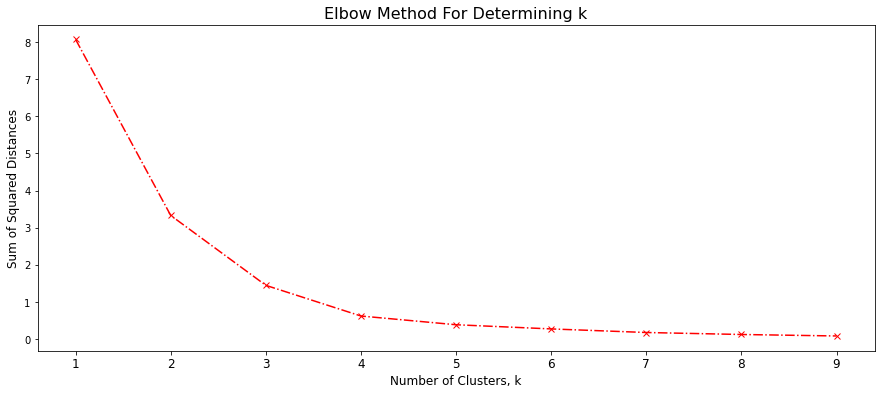

In [13]:
plot_elbow(freight_ratio)

Ideal clusters 4

In [14]:
k = 4
km = KMeans(n_clusters=k)
price_ratio['cluster_freight_ratio'] = km.fit_predict(freight_ratio)

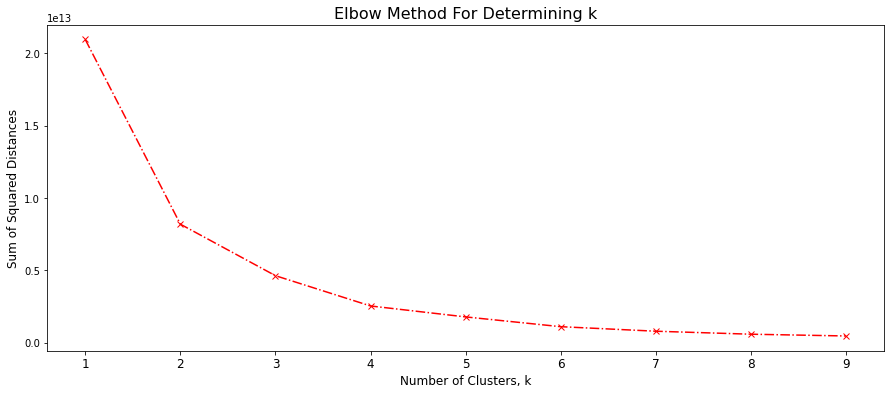

In [15]:
plot_elbow(price)

Ideal clusters 4

In [16]:
k = 4
km = KMeans(n_clusters=k)
price_ratio['cluster_price'] = km.fit_predict(price)

In [17]:
df1 = df.reset_index().merge(price_ratio.reset_index(), on = 'gtin')

Get dummies

In [18]:
vars_cat = ['weekday', 'week', 'month', 'monthday','cluster_price_ratio', 'cluster_freight_ratio', 'cluster_price']
df_dummies = pd.get_dummies(df1, columns = vars_cat, drop_first=True)

In [19]:
df_dummies.head(3)

,index,date,competition_price,gtin,item_name,orders,olist_price,freight_value,price_ratio_x,freight_ratio,...,monthday_29,monthday_30,monthday_31,cluster_price_ratio_1,cluster_freight_ratio_1,cluster_freight_ratio_2,cluster_freight_ratio_3,cluster_price_1,cluster_price_2,cluster_price_3
0,8,2019-03-05,1819.1,0190198057792,"Iphone 6 32 GB Dourado, Tela 4.7 IOS 8, Câmera...",1.0,1819.1,36.23,1.0,0.019916,...,0,0,0,0,0,0,0,0,0,0
1,18,2019-03-15,1819.1,0190198057792,"Iphone 6 32 GB Dourado, Tela 4.7 IOS 8, Câmera...",1.0,1819.1,84.98,1.0,0.046715,...,0,0,0,0,0,0,0,0,0,0
2,21,2019-03-18,1819.1,0190198057792,"Iphone 6 32 GB Dourado, Tela 4.7 IOS 8, Câmera...",1.0,1819.1,32.94,1.0,0.018108,...,0,0,0,0,0,0,0,0,0,0


train and test split

In [20]:
date_min = df_dummies['date'].min()
print(date_min)
date_max = df_dummies['date'].max()
print(date_max)
n_days_total =  len(df_dummies['date'].unique())
print(n_days_total)

2017-06-30 00:00:00
2020-02-28 00:00:00
974


In [21]:
#for time-series it's not a good idea subset train and test datasets randonly, because time is a important feature.
#n_test = number os rows used in test dataset.
n_test = 30 #days 
last_day_train = pd.to_timedelta(n_test, unit='d')
train = df_dummies[df_dummies['date'] < (date_max - last_day_train)]             
test  = df_dummies[df_dummies['date'] > (date_max - last_day_train)]             

Regressions

Base line

In [22]:
base_line = test.copy()
base_line['orders0'] = 0
base_line['orders_avg'] = base_line['orders'].mean()
print('Orders = 0 : MAE = ' + str(metrics.mean_absolute_error(test['orders'], base_line['orders0'])))
print('Orders = Avg : MAE = ' + str(metrics.mean_absolute_error(test['orders'], base_line['orders_avg'])))

Orders = 0 : MAE = 1.0266552020636286
Orders = Avg : MAE = 1.6740479290397257


In [23]:
train.columns.tolist()

['index',
 'date',
 'competition_price',
 'gtin',
 'item_name',
 'orders',
 'olist_price',
 'freight_value',
 'price_ratio_x',
 'freight_ratio',
 'competition_price_sc',
 'price_sc',
 'freight_sc',
 'trend',
 'price_ratio_y',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'week_9',
 'week_10',
 'week_11',
 'week_12',
 'week_13',
 'week_14',
 'week_15',
 'week_16',
 'week_17',
 'week_18',
 'week_19',
 'week_20',
 'week_21',
 'week_22',
 'week_23',
 'week_24',
 'week_25',
 'week_26',
 'week_27',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39',
 'week_40',
 'week_41',
 'week_42',
 'week_43',
 'week_44',
 'week_45',
 'week_46',
 'week_47',
 'week_48',
 'week_49',
 'week_50',
 'week_51',
 'week_52',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 '

In [24]:
formula = 'orders ~ trend + price_sc + competition_price_sc + freight_ratio + cluster_price_ratio_1 + cluster_freight_ratio_1 + \
             cluster_freight_ratio_2 + cluster_freight_ratio_3 + cluster_price_1 + cluster_price_2 + cluster_price_3'

model = smf.ols(formula = formula, data = train).fit()
metrics.mean_absolute_error(test['orders'], model.predict(test))

1.294509983501098

In [25]:
formula = 'orders ~ trend + price_sc + competition_price_sc + freight_ratio + \
            cluster_price_ratio_1 + cluster_freight_ratio_1 + cluster_freight_ratio_2 + cluster_freight_ratio_3 + cluster_price_1 + \
            cluster_price_2 + cluster_price_3 + \
            weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6'

model = smf.ols(formula = formula, data = train).fit()
metrics.mean_absolute_error(test['orders'], model.predict(test))

1.2931812070479518

In [26]:
y = ['orders']
x = ['trend', 'price_ratio_x', 'freight_ratio', 'competition_price_sc', 'price_sc', 'freight_sc',
     'weekday_1', 'weekday_2',  'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
     'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
     'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31','week_32', 'week_33', 'week_34',
     'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50',
     'week_51', 'week_52', 
     'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
     'monthday_2', 'monthday_3', 'monthday_4', 'monthday_5', 'monthday_6', 'monthday_7', 'monthday_8', 'monthday_9', 'monthday_10', 'monthday_11', 'monthday_12', 'monthday_13', 'monthday_14', 'monthday_15',
     'monthday_16', 'monthday_17', 'monthday_18', 'monthday_19', 'monthday_20', 'monthday_21', 'monthday_22', 'monthday_23', 'monthday_24', 'monthday_25', 'monthday_26', 'monthday_27', 'monthday_28', 'monthday_29', 'monthday_30', 'monthday_31',
     'cluster_price_ratio_1', 
     'cluster_freight_ratio_1', 'cluster_freight_ratio_2', 'cluster_freight_ratio_3', 
     'cluster_price_1', 'cluster_price_2', 'cluster_price_3']

model = DecisionTreeRegressor(max_depth = 5)
modelfit = model.fit(train[x], train[y])
modelpred = modelfit.predict(test[x])
metrics.mean_absolute_error(test[y], modelpred)

1.2014796499309102

In [28]:
y = ['orders']
x = ['trend', 'price_ratio_x', 'freight_ratio', 'competition_price_sc', 'price_sc', 'freight_sc',
     'weekday_1', 'weekday_2',  'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
     'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
     'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31','week_32', 'week_33', 'week_34',
     'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50',
     'week_51', 'week_52', 
     'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
     'monthday_2', 'monthday_3', 'monthday_4', 'monthday_5', 'monthday_6', 'monthday_7', 'monthday_8', 'monthday_9', 'monthday_10', 'monthday_11', 'monthday_12', 'monthday_13', 'monthday_14', 'monthday_15',
     'monthday_16', 'monthday_17', 'monthday_18', 'monthday_19', 'monthday_20', 'monthday_21', 'monthday_22', 'monthday_23', 'monthday_24', 'monthday_25', 'monthday_26', 'monthday_27', 'monthday_28', 'monthday_29', 'monthday_30', 'monthday_31',
     'cluster_price_ratio_1', 
     'cluster_freight_ratio_1', 'cluster_freight_ratio_2', 'cluster_freight_ratio_3', 
     'cluster_price_1', 'cluster_price_2', 'cluster_price_3']



model = RandomForestRegressor(n_estimators=1000, max_depth=5)
modelfit = model.fit(train[x], train[y])
modelpred = modelfit.predict(test[x])
metrics.mean_absolute_error(test[y], modelpred)

KeyboardInterrupt: 